![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Read the CSV file into a DataFrame
df = pd.read_csv('rental_info.csv')


In [20]:
# Display the first few rows of the dataset
print(df.head())

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Get summary statistics
print("Summary statistics:\n", df.describe())

# Check data types to confirm columns like 'rental_date' and 'return_date' are in datetime format
print("Data types:\n", df.dtypes)


                 rental_date  ... rental_rate_2
0  2005-05-25 02:54:33+00:00  ...        8.9401
1  2005-06-15 23:19:16+00:00  ...        8.9401
2  2005-07-10 04:27:45+00:00  ...        8.9401
3  2005-07-31 12:06:41+00:00  ...        8.9401
4  2005-08-19 12:30:04+00:00  ...        8.9401

[5 rows x 15 columns]
Missing values:
 rental_date         0
return_date         0
amount              0
release_year        0
rental_rate         0
length              0
replacement_cost    0
special_features    0
NC-17               0
PG                  0
PG-13               0
R                   0
amount_2            0
length_2            0
rental_rate_2       0
dtype: int64
Summary statistics:
              amount  release_year  ...      length_2  rental_rate_2
count  15861.000000  15861.000000  ...  15861.000000   15861.000000
mean       4.217161   2006.885379  ...  14832.841876      11.389287
std        2.360383      2.025027  ...   9393.431996      10.005293
min        0.990000   2004.000000  .

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of rental_length_days
plt.figure(figsize=(8, 6))
sns.histplot(df['rental_length_days'], kde=True, bins=20)
plt.title('Distribution of Rental Duration (Days)')
plt.xlabel('Rental Length (Days)')
plt.ylabel('Frequency')
plt.show()


KeyError: 'rental_length_days'

<Figure size 800x600 with 0 Axes>

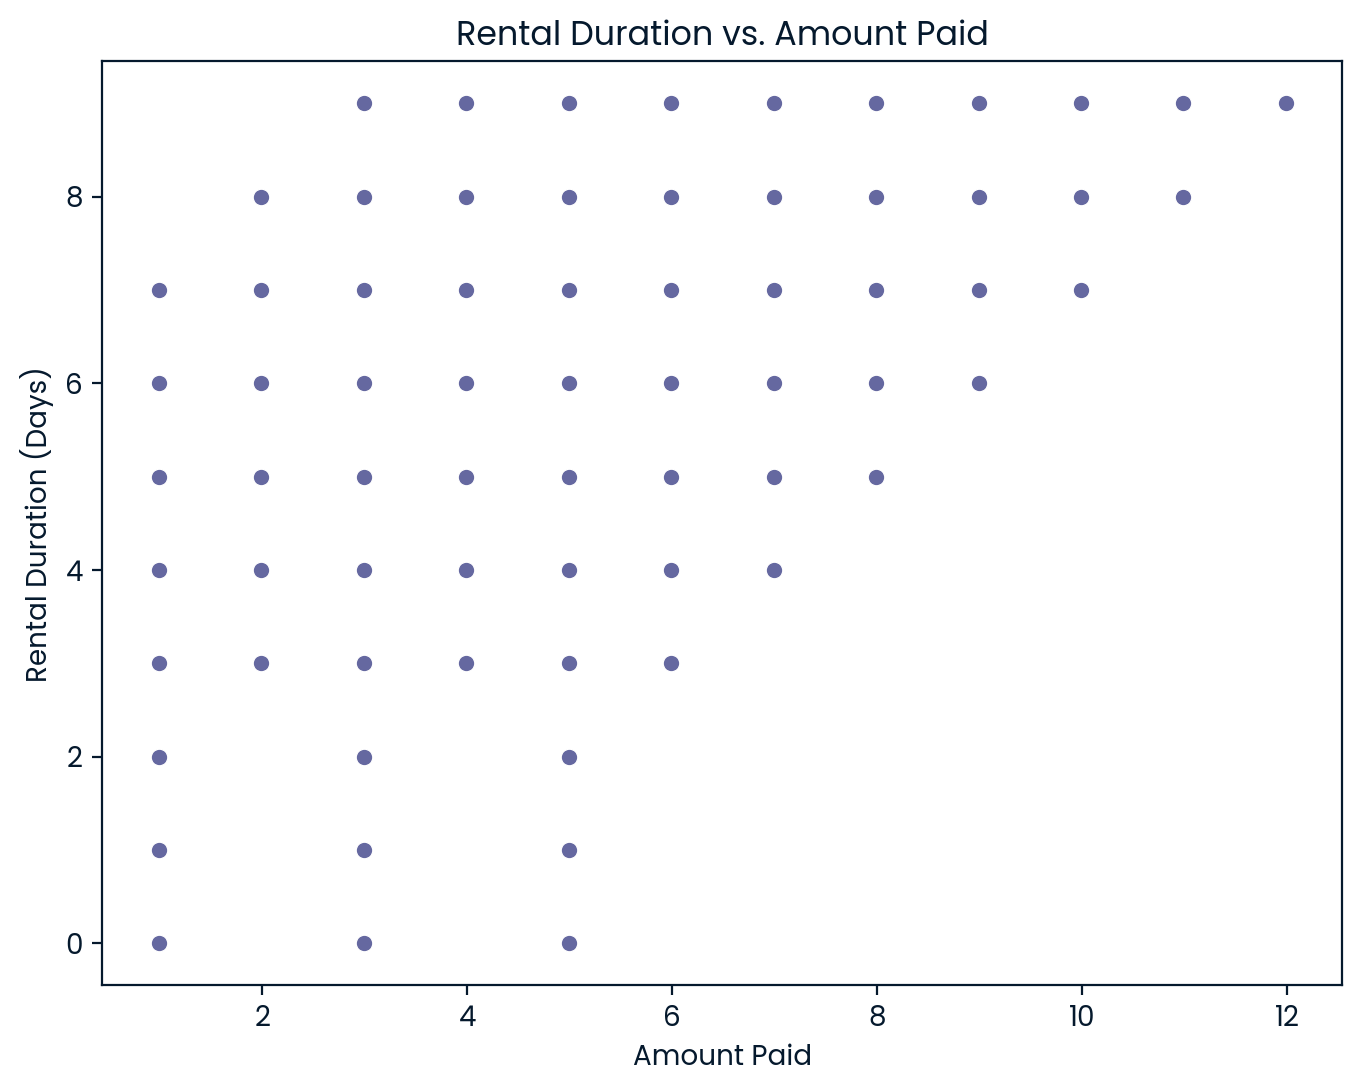

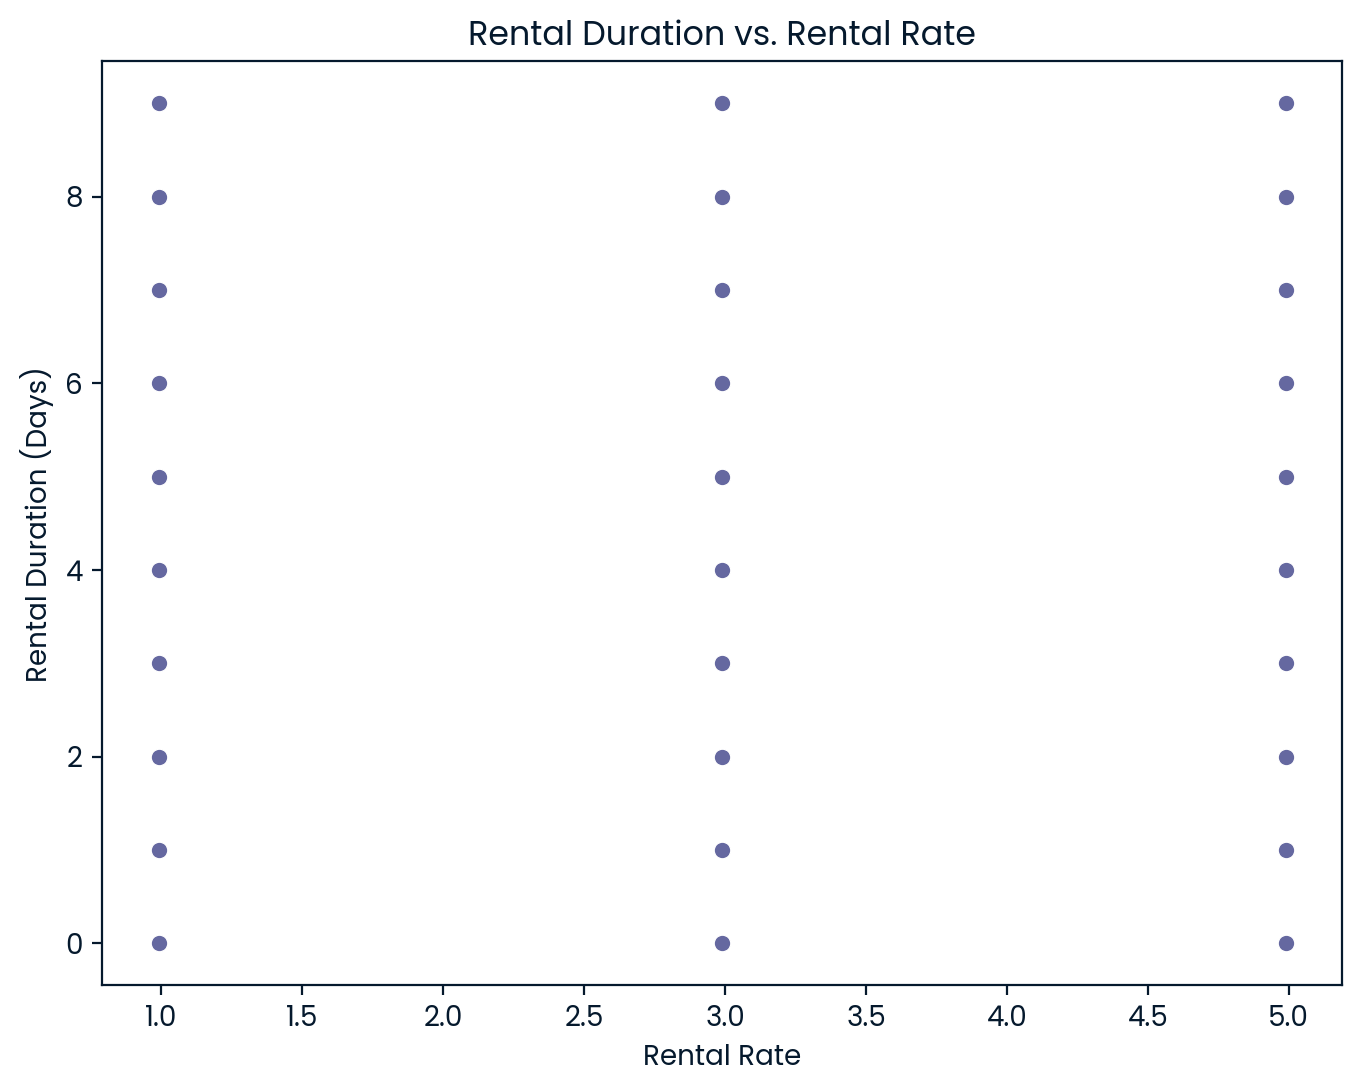

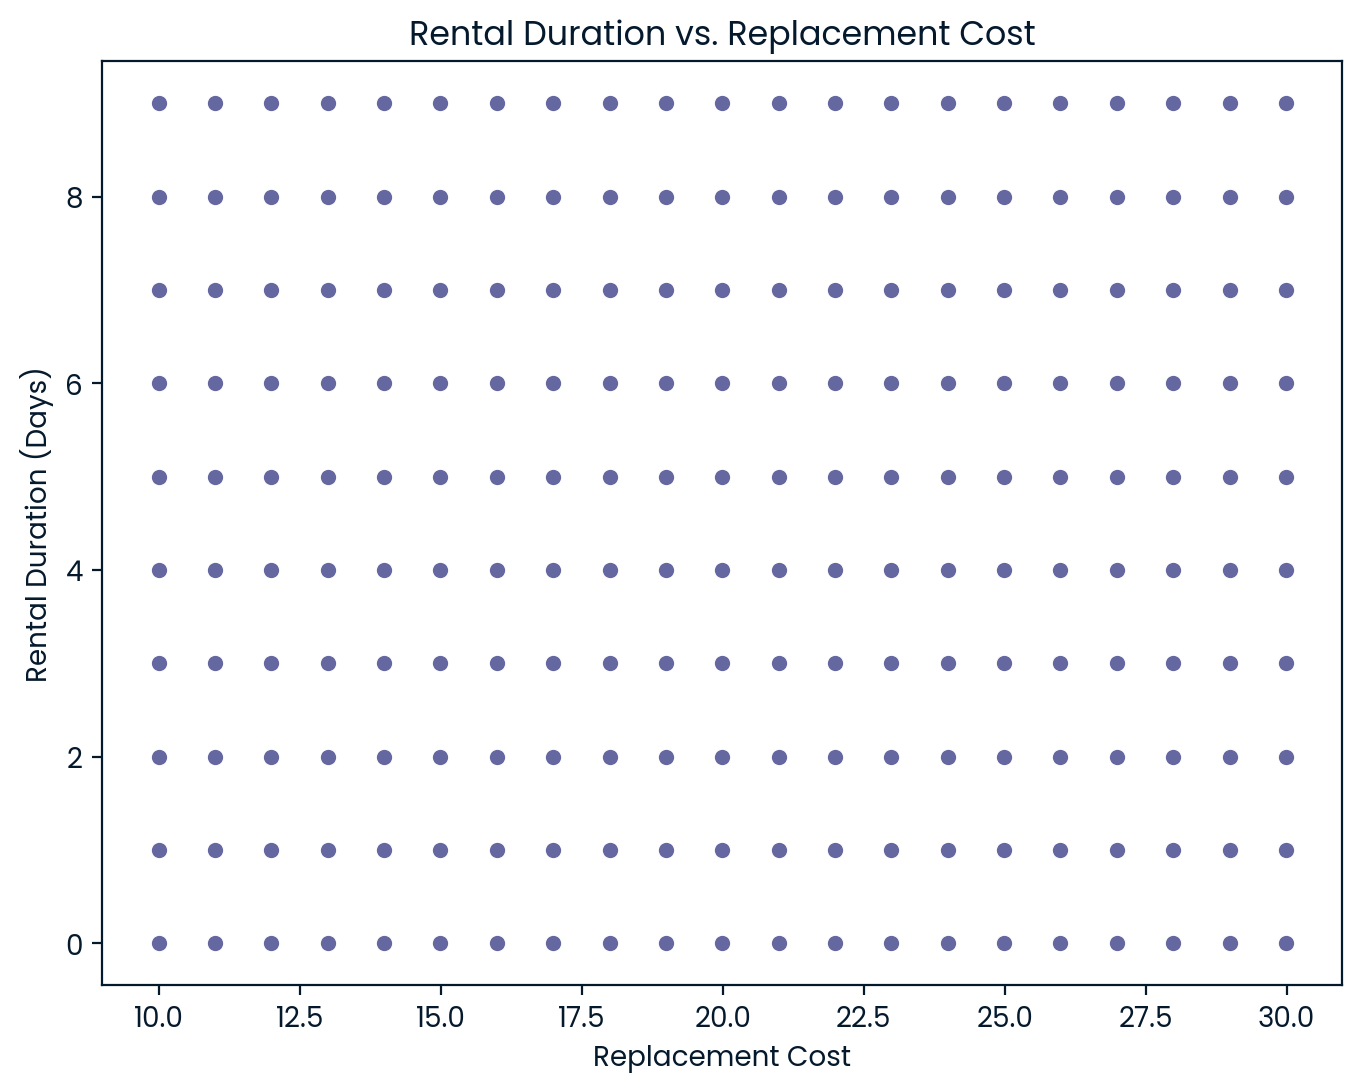

In [16]:
# Scatter plot for amount vs. rental_length_days
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='amount', y='rental_length_days')
plt.title('Rental Duration vs. Amount Paid')
plt.xlabel('Amount Paid')
plt.ylabel('Rental Duration (Days)')
plt.show()

# Scatter plot for rental_rate vs. rental_length_days
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='rental_rate', y='rental_length_days')
plt.title('Rental Duration vs. Rental Rate')
plt.xlabel('Rental Rate')
plt.ylabel('Rental Duration (Days)')
plt.show()

# Scatter plot for replacement_cost vs. rental_length_days
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='replacement_cost', y='rental_length_days')
plt.title('Rental Duration vs. Replacement Cost')
plt.xlabel('Replacement Cost')
plt.ylabel('Rental Duration (Days)')
plt.show()


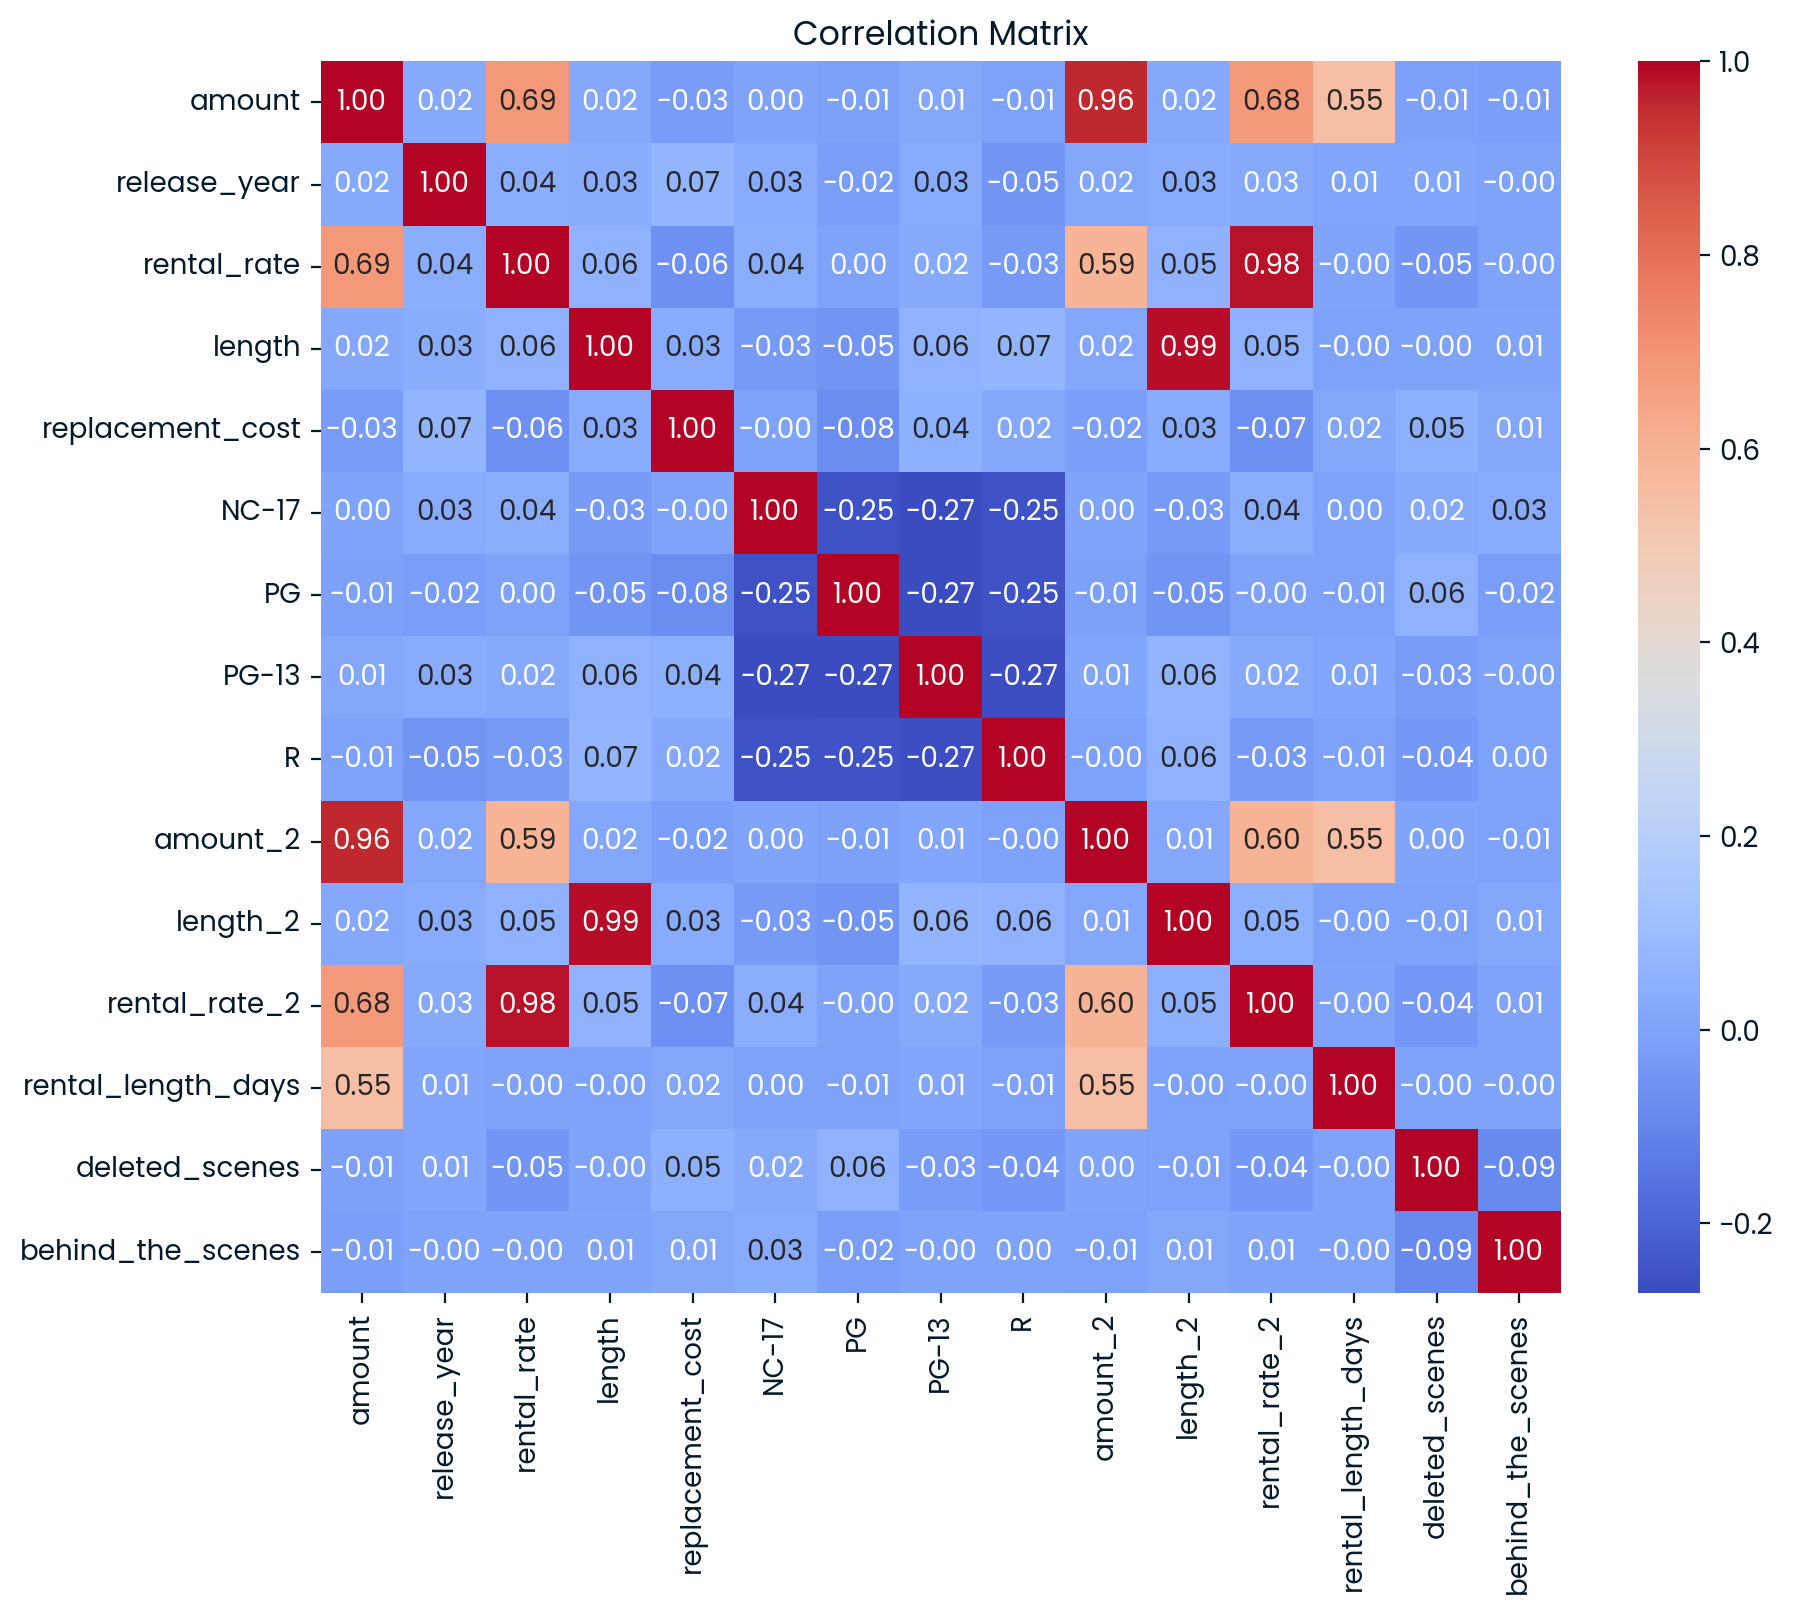

In [17]:
# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


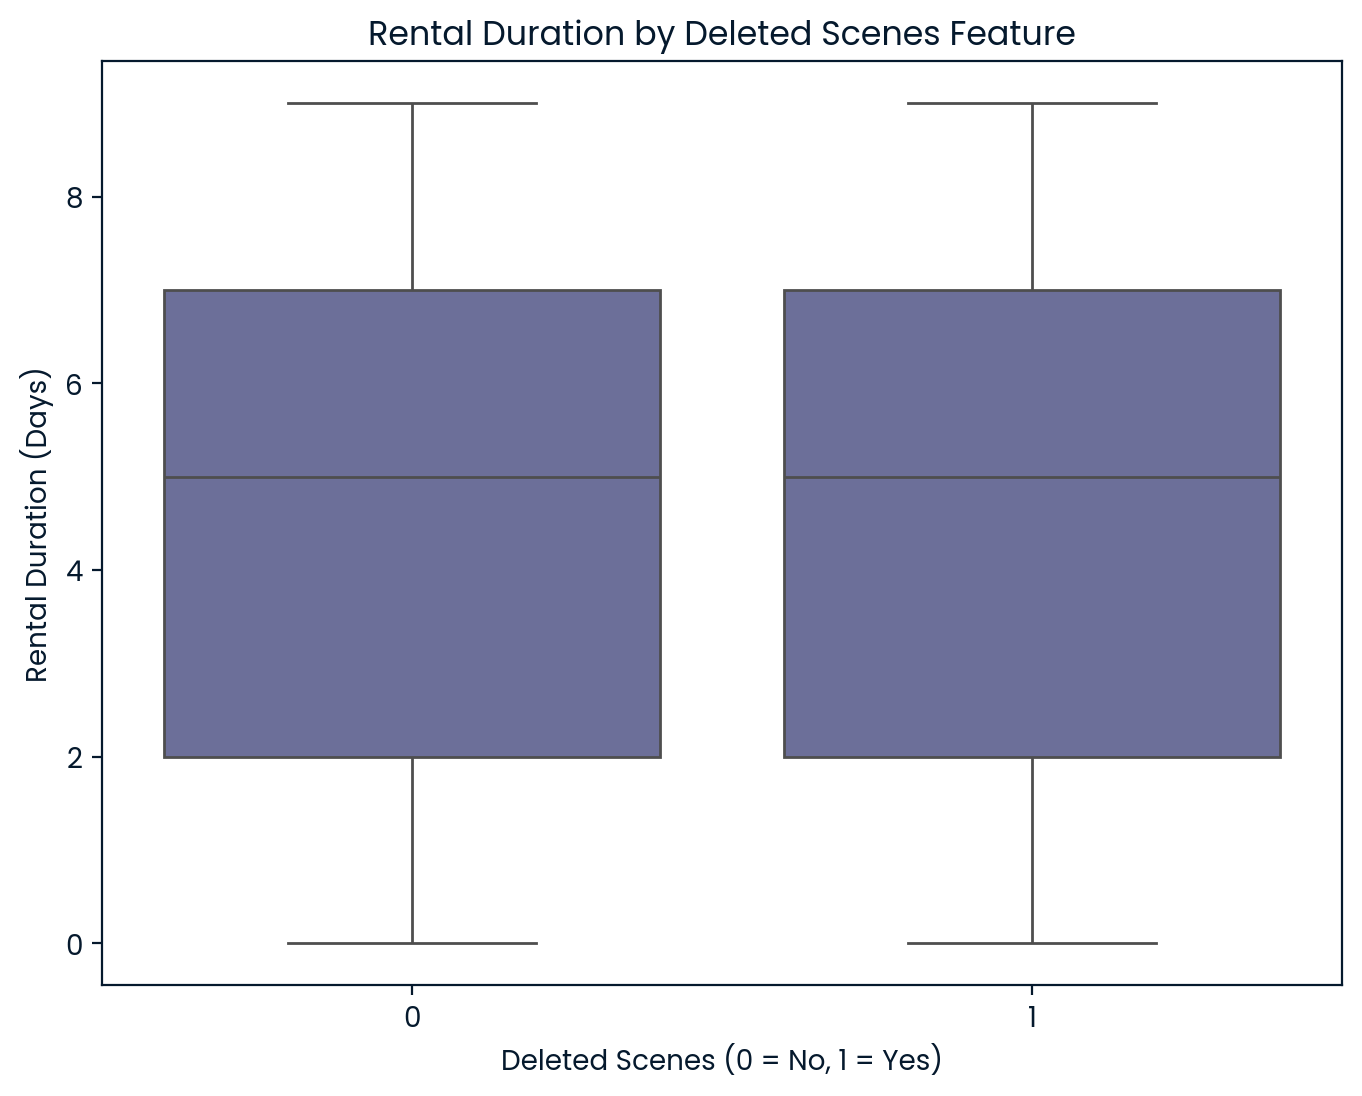

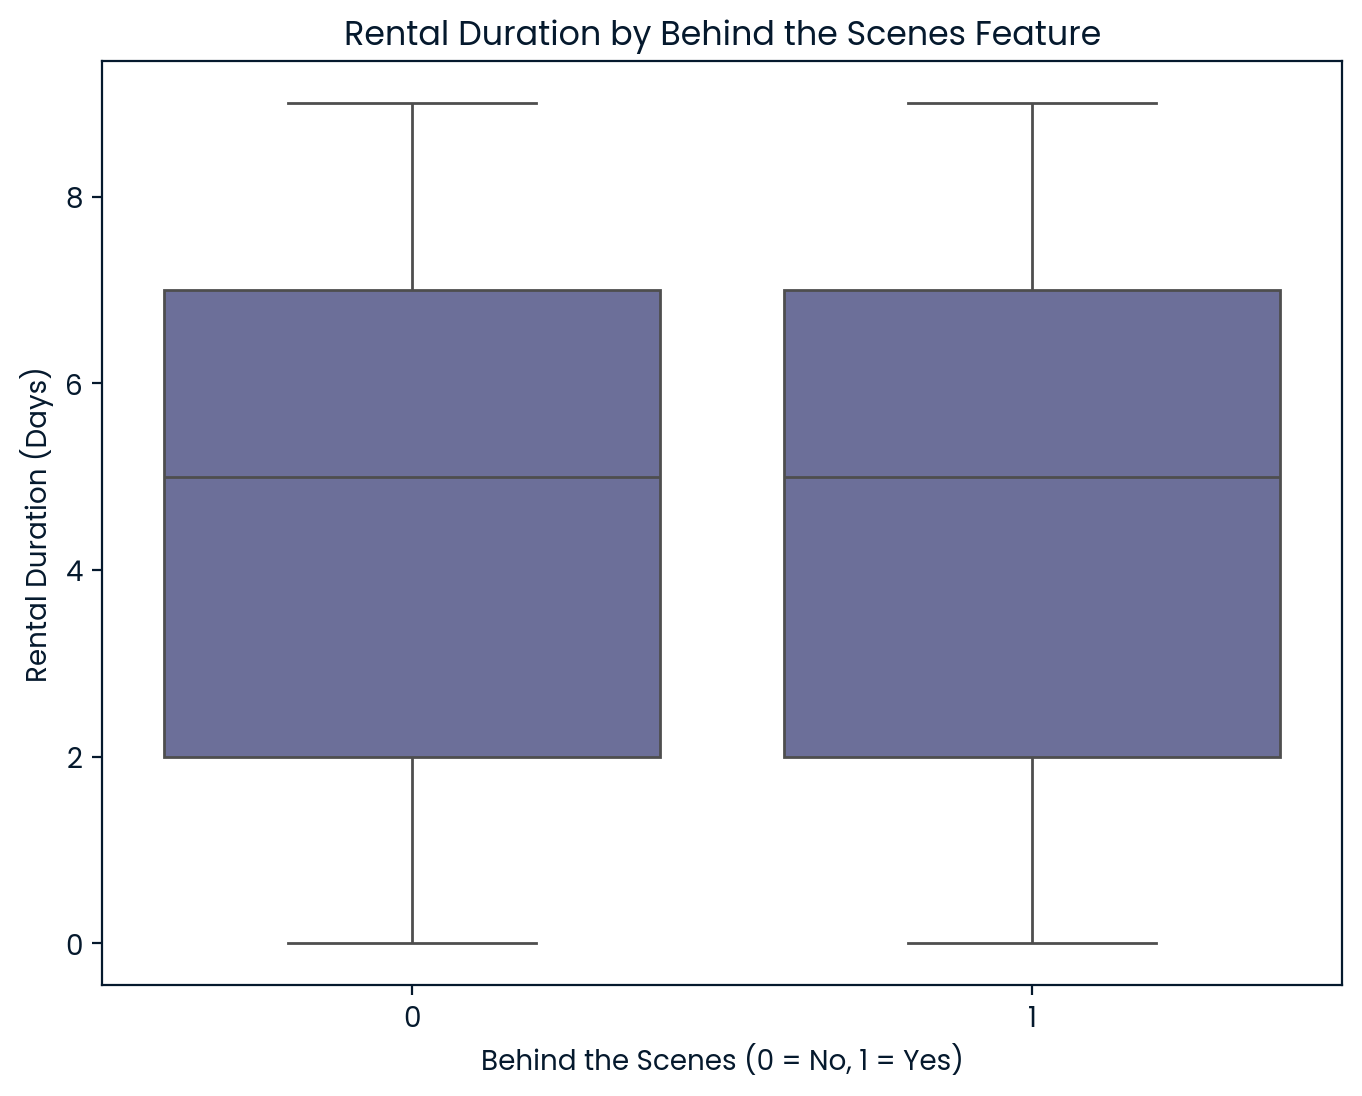

In [18]:
# Box plot for rental_length_days by deleted_scenes
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='deleted_scenes', y='rental_length_days')
plt.title('Rental Duration by Deleted Scenes Feature')
plt.xlabel('Deleted Scenes (0 = No, 1 = Yes)')
plt.ylabel('Rental Duration (Days)')
plt.show()

# Box plot for rental_length_days by behind_the_scenes
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='behind_the_scenes', y='rental_length_days')
plt.title('Rental Duration by Behind the Scenes Feature')
plt.xlabel('Behind the Scenes (0 = No, 1 = Yes)')
plt.ylabel('Rental Duration (Days)')
plt.show()


In [8]:
# Convert date columns to datetime
df['rental_date'] = pd.to_datetime(df['rental_date'])
df['return_date'] = pd.to_datetime(df['return_date'])

# Calculate rental length in days
df['rental_length_days'] = (df['return_date'] - df['rental_date']).dt.days


In [9]:
# Create dummy variables
df['deleted_scenes'] = df['special_features'].apply(lambda x: 1 if 'Deleted Scenes' in str(x) else 0)
df['behind_the_scenes'] = df['special_features'].apply(lambda x: 1 if 'Behind the Scenes' in str(x) else 0)


In [10]:
# Define X (features) and y (target)
X = df.drop(columns=['rental_date', 'return_date', 'special_features', 'rental_length_days'])
y = df['rental_length_days']


In [11]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)


In [12]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=9),
    'Random Forest': RandomForestRegressor(random_state=9)
}

# Store the best model and MSE
best_model = None
best_mse = float('inf')

# Iterate over models
for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} MSE: {mse:.4f}")
    
    # Check if this model has the lowest MSE and meets the threshold
    if mse < best_mse and mse <= 3:
        best_mse = mse
        best_model = model

# Display the best model and its MSE
print(f"Best Model: {best_model}")
print(f"Best MSE: {best_mse:.4f}")


Linear Regression MSE: 2.9417
Decision Tree MSE: 2.1675
Random Forest MSE: 2.0301
Best Model: RandomForestRegressor(random_state=9)
Best MSE: 2.0301
